<a href="https://colab.research.google.com/github/pavankalyan066/Natural-Language-Processing/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
# to unzip the csv file
!unzip /content/archive.zip 

Archive:  /content/archive.zip
  inflating: news_articles.csv       


In [3]:
data = pd.read_csv('/content/news_articles.csv')

In [5]:
data.head(2)

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0


In [6]:
data['label'].value_counts()

Fake    1294
Real     801
Name: label, dtype: int64

In [7]:
data = data[['title', 'label']]

In [8]:
data.head()

,title,label
0,muslims busted they stole millions in govt ben...,Real
1,re why did attorney general loretta lynch plea...,Real
2,breaking weiner cooperating with fbi on hillar...,Real
3,pin drop speech by father of daughter kidnappe...,Real
4,fantastic trumps point plan to reform healthc...,Real


In [10]:
data['label'] = data['label'].map({'Real': 0, 'Fake':1})

In [17]:
data.tail()

,title,label
2090,prof canoes reek of genocide white privilege,0.0
2091,teens walk free after gangrape conviction,0.0
2092,school named for munichmassacre mastermind,0.0
2093,russia unveils satan missile,1.0
2094,check out hillarythemed haunted house,1.0


In [13]:
data = data.dropna()

In [16]:
data['label'].value_counts()

1.0    1294
0.0     801
Name: label, dtype: int64

We have a approximately 62:38 real:fake news ratio.

Mean Length 61.22673031026253
Min Length 2
Max Length 443


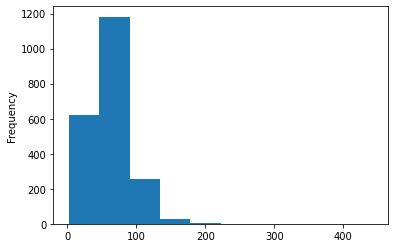

In [25]:
# Character Length of Titles - Min, Mean, Max
print('Mean Length', data['title'].apply(len).mean())
print('Min Length', data['title'].apply(len).min())
print('Max Length', data['title'].apply(len).max())

x = data['title'].apply(len).plot.hist()

We see that that the numbers of characters in each entry ranges from 2–443. There is a high concentration of samples with a length of 0–100. This can be further seen with the mean length in the dataset being approximately 61.